<a href="https://colab.research.google.com/github/paulovitorcl/automato-celular/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-9217a7c7fca0>:153: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imagens.append(imageio.imread(os.path.join(pasta, file)))


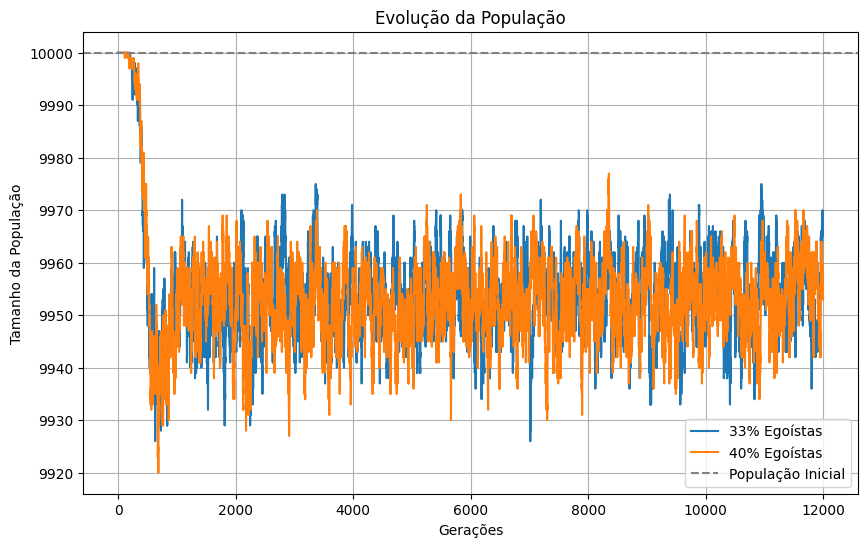

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
import os

# Parâmetros
TAMANHO = 100  # Matriz 100x100
GERACOES = 12000  # Número de gerações
TAXA_ALTRUISTAS = 0.33
TAXA_VINGATIVOS = 0.34
MAX_PARASITAS = 8
TAXA_NASCIMENTOS = 0.05  # Proporção de nascimentos por geração

# Estados
VAZIO = 0
EGOISTA = 1
ALTRUISTA = 2
VINGATIVO = 3

# Inicializar população
def inicializar_populacao(taxa_egoistas):
    populacao = np.zeros((TAMANHO, TAMANHO), dtype=int)
    parasitas = np.zeros((TAMANHO, TAMANHO), dtype=int)
    memoria_vingativo = np.zeros((TAMANHO, TAMANHO), dtype=bool)

    total_individuos = TAMANHO * TAMANHO
    indices = list(range(total_individuos))
    random.shuffle(indices)

    egoistas = int(taxa_egoistas * total_individuos)
    altruistas = int(TAXA_ALTRUISTAS * total_individuos)
    vingativos = int(TAXA_VINGATIVOS * total_individuos)

    for i in indices[:egoistas]:
        populacao[i // TAMANHO][i % TAMANHO] = EGOISTA
    for i in indices[egoistas:egoistas + altruistas]:
        populacao[i // TAMANHO][i % TAMANHO] = ALTRUISTA
    for i in indices[egoistas + altruistas:egoistas + altruistas + vingativos]:
        populacao[i // TAMANHO][i % TAMANHO] = VINGATIVO

    return populacao, parasitas, memoria_vingativo

# Obter vizinhos de Von Neumann
def obter_vizinhos(x, y):
    vizinhos = []
    if x > 0: vizinhos.append((x - 1, y))
    if x < TAMANHO - 1: vizinhos.append((x + 1, y))
    if y > 0: vizinhos.append((x, y - 1))
    if y < TAMANHO - 1: vizinhos.append((x, y + 1))
    return vizinhos

# Regras de interação
def interagir(individuo, vizinho, parasitas, memoria_vingativo, x_vizinho, y_vizinho):
    if vizinho == VAZIO:
        return individuo, memoria_vingativo

    if individuo == ALTRUISTA:
        parasitas[x_vizinho, y_vizinho] = max(0, parasitas[x_vizinho, y_vizinho] - 1)
        return individuo, memoria_vingativo

    elif individuo == EGOISTA:
        return individuo, memoria_vingativo

    elif individuo == VINGATIVO:
        if not memoria_vingativo:
            parasitas[x_vizinho, y_vizinho] = max(0, parasitas[x_vizinho, y_vizinho] - 1)
            memoria_vingativo = True
        return individuo, memoria_vingativo

    return individuo, memoria_vingativo

# Simular uma geração
def simular_geracao(populacao, parasitas, memoria_vingativo):
    nova_populacao = populacao.copy()
    novos_parasitas = parasitas.copy()
    nova_memoria = memoria_vingativo.copy()

    for i in range(TAMANHO):
        for j in range(TAMANHO):
            if populacao[i][j] != VAZIO:
                vizinhos = obter_vizinhos(i, j)
                if vizinhos:
                    x_vizinho, y_vizinho = random.choice(vizinhos)
                    novo_estado, nova_memoria[i, j] = interagir(
                        populacao[i][j],
                        populacao[x_vizinho, y_vizinho],
                        novos_parasitas,
                        nova_memoria[i, j],
                        x_vizinho,
                        y_vizinho
                    )
                    nova_populacao[i, j] = novo_estado

    # Adicionar novos parasitas
    for _ in range(TAMANHO):
        x, y = random.randint(0, TAMANHO - 1), random.randint(0, TAMANHO - 1)
        if nova_populacao[x, y] != VAZIO:
            novos_parasitas[x, y] += 1

    # Nascimentos
    for _ in range(int(TAXA_NASCIMENTOS * TAMANHO * TAMANHO)):
        x, y = random.randint(0, TAMANHO - 1), random.randint(0, TAMANHO - 1)
        if nova_populacao[x, y] == VAZIO:
            nova_populacao[x, y] = random.choice([EGOISTA, ALTRUISTA, VINGATIVO])

    # Eliminar indivíduos com muitos parasitas
    for i in range(TAMANHO):
        for j in range(TAMANHO):
            if novos_parasitas[i, j] >= MAX_PARASITAS:
                nova_populacao[i, j] = VAZIO
                novos_parasitas[i, j] = 0

    return nova_populacao, novos_parasitas, nova_memoria

# Executar simulação
def executar_simulacao(taxa_egoistas, nome_pasta, gif_output):
    populacao, parasitas, memoria_vingativo = inicializar_populacao(taxa_egoistas)
    populacoes = []
    tamanhos_populacao = []

    for gen in range(GERACOES):
        populacao, parasitas, memoria_vingativo = simular_geracao(populacao, parasitas, memoria_vingativo)
        populacoes.append(populacao)
        tamanhos_populacao.append(np.count_nonzero(populacao != VAZIO))

    # Salvar imagens e GIF
    salvar_imagens(populacoes, nome_pasta, interval=100)
    gerar_gif(nome_pasta, gif_output)

    return tamanhos_populacao

# Salvar imagens de cada geração
def salvar_imagens(populacoes, pasta, interval):
    if not os.path.exists(pasta):
        os.makedirs(pasta)
    for idx, populacao in enumerate(populacoes):
        if idx % interval == 0:
            plt.figure(figsize=(10, 10))
            cmap = ListedColormap(['white', 'red', 'blue', 'green'])
            plt.imshow(populacao, cmap=cmap, interpolation='nearest')
            plt.title(f"Geração {idx}")
            plt.colorbar(ticks=[0, 1, 2, 3], label="Caracteres")
            plt.savefig(f"{pasta}/geracao_{idx:04d}.png")
            plt.close()

# Gerar GIF
def gerar_gif(pasta, output):
    imagens = []
    for file in sorted(os.listdir(pasta)):
        if file.endswith(".png"):
            imagens.append(imageio.imread(os.path.join(pasta, file)))
    imageio.mimsave(output, imagens, duration=0.3)

# Configurações e execução
tamanhos_33 = executar_simulacao(0.33, "imagens_33", "evolucao_33.gif")
tamanhos_40 = executar_simulacao(0.40, "imagens_40", "evolucao_40.gif")

# Gráfico de comparação
plt.figure(figsize=(10, 6))
plt.plot(range(GERACOES), tamanhos_33, label="33% Egoístas")
plt.plot(range(GERACOES), tamanhos_40, label="40% Egoístas")
plt.axhline(10000, color="gray", linestyle="--", label="População Inicial")
plt.title("Evolução da População")
plt.xlabel("Gerações")
plt.ylabel("Tamanho da População")
plt.legend()
plt.grid()
plt.show()
